# Model of technological innovation from Torsten Heinrich's PhD thesis

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def innovate(n_tick=100,
             n_firm=128,
             cost_plant=1.6,
             life_plant=20,
             labour_available=32,
             plant_production=0.25,
             n_tech_type=20,
             improvement_power=1.0/32.0,
             p_innovate=0.1,
             p_compatible=0.5,
             p_open=0.1,
             seed=None,
             verbose=True):
    """Simulation of technological innovation within an industry."""
    
    # Set randomness
    rng = np.random.RandomState(seed)
    
    # Each firm starts with enough funds to make exactly one plant
    firms = pd.DataFrame({
        'funds': np.zeros(n_firm) + cost_plant,
        'best_tech': 0,
        'income': 0.0,
        'labour': 0.0,
        'open': rng.rand(n_firm) < p_open,
    })
    
    # Initially there are no plants
    plants = pd.DataFrame(columns=['firm', 'technology', 'life', 'a', 'n_plant', 'n_active'])
    
    # Initially there is only the most basic technology
    technology = pd.DataFrame({
        'innovator': [-1],
        'tech_type': [-1],
        'open': [True],
        'raw_a': [1.0],
        'a': [1.0],
        'precursor': [-1],
        'tick': [-1],
    })
    
    # Initially everybody knows that basic technology
    knowledge = pd.DataFrame({
        'firm': np.arange(n_firm, dtype=int),
        'technology': 0,
        'a': 1.0,
    })
    
    # Results will go here
    history = pd.DataFrame(columns=['production', 'labour', 'herfindahl', 'max_share',
                                    'best_a', 'worst_a', 'mean_a', 'best_open', 'n_live', 'n_active'],
                           index=range(n_tick))
    
    for tick in xrange(n_tick):
        
        if verbose:
            print tick
        
        # All firms build as many plants as they can with their best available technology
        n_construct = np.floor(firms['funds'] / cost_plant).astype(int)
        n_construct = n_construct[n_construct > 0]
        new_plants_tech = firms.loc[n_construct.index, 'best_tech'].values
        new_plants = pd.DataFrame({
            'firm': n_construct.index,
            'technology': new_plants_tech,
            'life': life_plant,
            'a': technology.loc[new_plants_tech, 'a'].values,
            'n_plant': n_construct.values,
            'n_active': 0,
        })
        firms.loc[n_construct.index, 'funds'] -= n_construct.values * cost_plant
        plants = pd.concat([plants, new_plants]).reset_index(drop=True)
        
        # Allocate labour to the most efficient operational plants
        plants_sorted = plants[plants['life'] > 0].sort_values('a')
        required_labour = plants_sorted['a'] * plants_sorted['n_plant'] * plant_production
        # All plants at this technology level are active
        all_active = required_labour.cumsum() <= labour_available
        all_active = all_active.index[all_active]
        plants['n_active'] = 0
        plants.loc[all_active, 'n_active'] = plants.loc[all_active, 'n_plant']
        if len(all_active) != len(required_labour):
            # For the next technology technology level, some of the plants will be active
            remaining_labour = labour_available - required_labour.loc[all_active].sum()
            next_idx = required_labour.index[len(all_active)]
            next_plants = plants_sorted.loc[next_idx]
            plants.loc[next_idx, 'n_active'] = int(np.floor(remaining_labour / (next_plants['a'] * plant_production)))
        active = plants['n_active'] > 0
        
        # Produce in all active plants
        production = plants['n_active'].groupby(plants['firm']).sum() * plant_production
        production = production.loc[firms.index].fillna(0.0)
        firms['funds'] += production
        firms['income'] += production

        # Record the labour costs
        labour = (plants['n_active'] * plants['a']).groupby(plants['firm']).sum() * plant_production
        labour_all = labour.loc[firms.index].fillna(0.0)
        firms['labour'] += labour_all
        
        # Do research
        innovators = np.where(rng.rand(n_firm) < p_innovate)[0]
        rng.shuffle(innovators)
        new_a = rng.rand(len(innovators)) ** improvement_power
        new_tech = pd.DataFrame({
            'innovator': innovators,
            'tech_type': -1,
            'open': firms.loc[innovators, 'open'].values,
            'raw_a': new_a,
            'a': new_a,
            'precursor': -1,
            'tick': tick
        }, index=range(len(technology), len(technology) + len(innovators)))

        # Spread knowledge ('a' values will be updated as we go through the technologies)
        new_tech_closed = new_tech[~new_tech['open']]
        new_knowledge_closed = pd.DataFrame({
            'firm': new_tech_closed['innovator'].values,
            'technology': new_tech_closed.index.values,
            'a': 1.0,
        })
        new_tech_open = new_tech[new_tech['open']]
        new_knowledge_open = pd.DataFrame({
            'firm': (np.arange(n_firm, dtype=int)[:, None] *
                     np.ones(len(new_tech_open), dtype=int)[None, :]).ravel(),
            'technology': (np.ones(n_firm, dtype=int)[:, None] *
                           new_tech_open.index.values).ravel(),
            'a': 1.0,
        })
        knowledge = pd.concat([knowledge, new_knowledge_closed, new_knowledge_open]).reset_index(drop=True)

        for idx, tech in new_tech.iterrows():
            # Check for compatible technologies and update a accordingly
            also_known = knowledge[knowledge['firm'] == tech['innovator']]
            compatible = also_known[rng.rand(len(also_known)) < p_compatible]
            if len(compatible) > 0:
                best = compatible.loc[compatible['a'].argmin()]
            else:
                best = pd.Series({'a': 1.0, 'technology': -1})
            new_tech.loc[idx, 'a'] *= best['a']
            new_tech.loc[idx, 'precursor'] = best['technology']
            knowledge.loc[knowledge['technology'] == idx, 'a'] = new_tech.loc[idx, 'a']
        technology = technology.append(new_tech)

        # Update best technology for each firm
        firms['best_tech'] = knowledge.loc[knowledge.groupby('firm')['a'].apply(np.argmin), 'technology'].values

        # Data manipulations to store in outputs
        share = production / production.sum()
        herfindahl = (np.sum(share**2) - (1.0 / n_firm)) / (1.0 - (1.0 / n_firm))
        
        # Save history
        history.loc[tick] = {
            'production': production.sum(),
            'labour': labour.sum(),
            'herfindahl': herfindahl,
            'max_share': share.max(),
            'best_a': plants.loc[active, 'a'].min(),
            'worst_a': plants.loc[active, 'a'].max(),
            'mean_a': (plants['a'] * plants['n_active']).sum() / plants['n_active'].sum(),
            'best_open': technology.loc[technology['open'], 'a'].min(),
            'n_live': plants_sorted['n_plant'].sum(),
            'n_active': plants['n_active'].sum(),
        }
        
        # Plants decay
        plants['life'] -= 1
    
    return {'firms': firms, 'plants': plants, 'technology': technology,
            'knowledge': knowledge, 'history': history}

In [3]:
def summarise(rep):
    """Make a summary of results from a single replication, returning a pandas Series."""
    result = rep['history'].iloc[-1].copy()
    result.index = 'final_' + result.index
    n_active = rep['plants'].groupby('firm')['n_active'].sum().sort_index()
    result.loc['mean_n_active_open'] = n_active[rep['firms']['open']].mean()
    result.loc['mean_n_active_closed'] = n_active[~rep['firms']['open']].mean()
    result.loc['mean_income_open'] = rep['firms'][rep['firms']['open']]['income'].mean()
    result.loc['mean_income_closed'] = rep['firms'][~rep['firms']['open']]['income'].mean()
    result.loc['mean_best_a_open'] = rep['technology'].loc[rep['firms'].loc[rep['firms']['open'], 'best_tech'], 'a'].mean()
    result.loc['mean_best_a_closed'] = rep['technology'].loc[rep['firms'].loc[~rep['firms']['open'], 'best_tech'], 'a'].mean()
    return result

In [4]:
# Make some results from individual replications
result_list = []
p_open_values = [0.0, 0.1, 0.2, 0.5, 1.0]
for p_open in p_open_values:
    print datetime.now()
    print p_open
    result_list.append(innovate(p_open=p_open, verbose=False))
print datetime.now()

2017-11-22 13:27:44.868997
0.0
2017-11-22 13:27:55.241227
0.1
2017-11-22 13:28:05.480571
0.2
2017-11-22 13:28:15.679031
0.5
2017-11-22 13:28:26.615928
1.0
2017-11-22 13:28:38.348527


/Users/jallen/miniconda2/envs/catapult/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


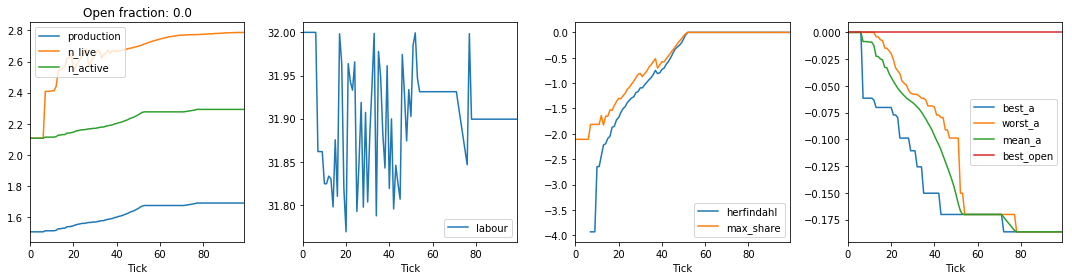

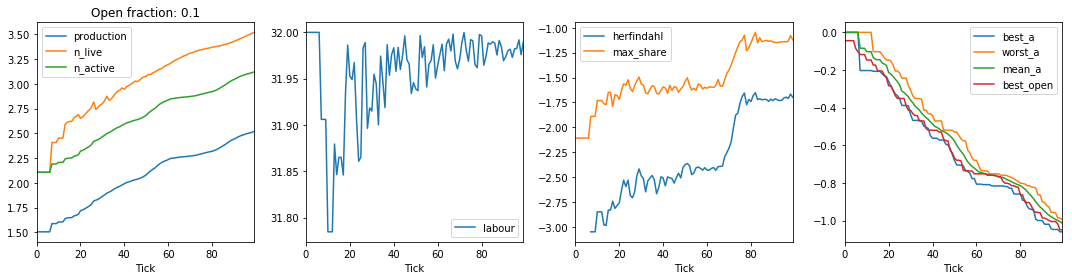

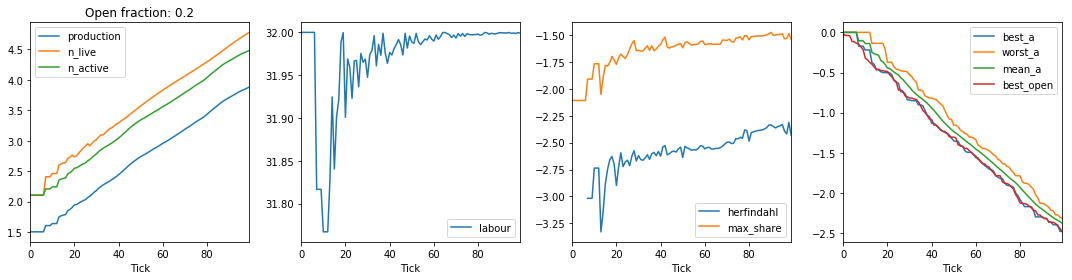

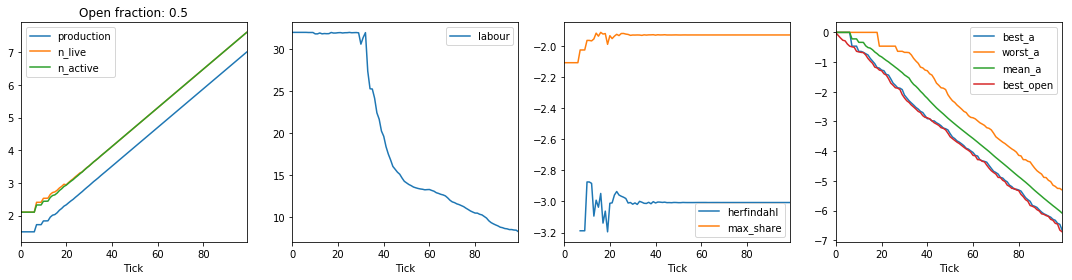

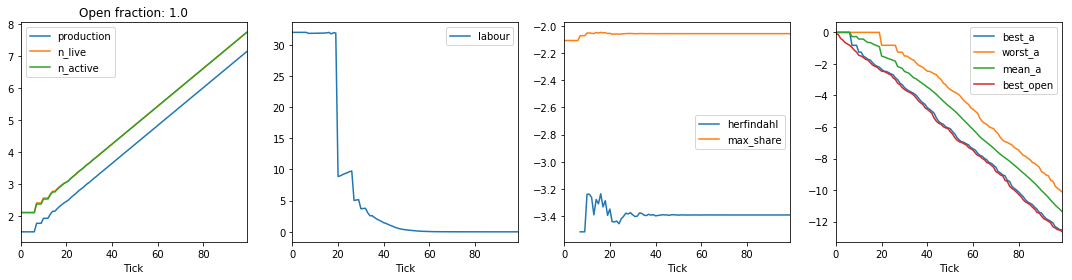

In [36]:
# Plot the results, with increasing openness as you descend
configs = (
    (True, ['production', 'n_live', 'n_active']),
    (False, ['labour']),
    (True, ['herfindahl', 'max_share']),
    (True, ['best_a', 'worst_a', 'mean_a', 'best_open']),
)

for p_idx, res in enumerate(result_list):
    fig = plt.figure(figsize=(15, 4))
    for idx, (log, cols) in enumerate(configs):
        ax = fig.add_subplot(1, len(configs), idx + 1)
        data = res['history'][cols].astype(float)
        if log:
            data = np.log10(data)
        data.plot(ax=ax)
        plt.xlabel('Tick')
        if idx == 0:
            plt.title('Open fraction: {}'.format(p_open_values[p_idx]))
    plt.tight_layout()

Low openness results in low production, high employment, monopolies and poor technology.

High openness results in excellent technology, low employment, competition and good technology.

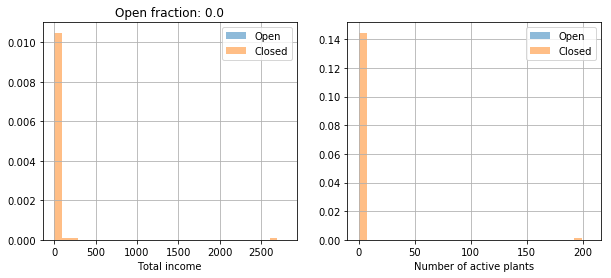

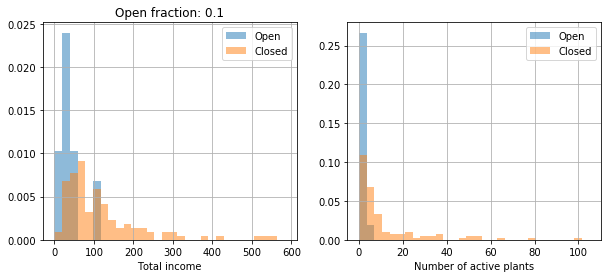

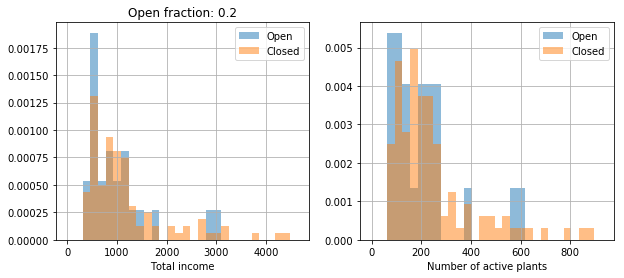

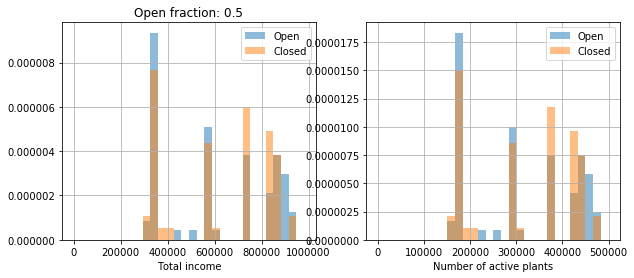

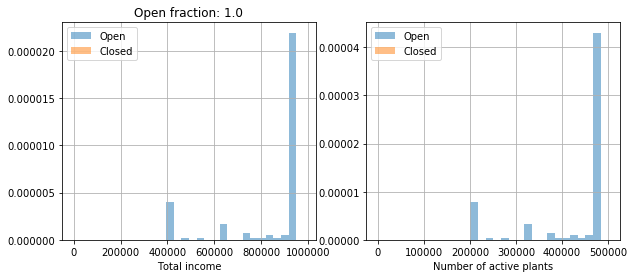

In [37]:
# Plot distribution of income for each openness value
for p_open, result in zip(p_open_values, result_list):
    fig = plt.figure(figsize=(10, 4))
    firms = result['firms']
    plants = result['plants']
    
    fig.add_subplot(121)
    bins = np.linspace(0, firms['income'].max()*1.05, 31, endpoint=True)
    firms['income'][firms['open']].hist(bins=bins, alpha=0.5, normed=True, label='Open')
    firms['income'][~firms['open']].hist(bins=bins, alpha=0.5, normed=True, label='Closed')
    plt.legend()
    plt.xlabel('Total income')
    plt.title('Open fraction: {}'.format(p_open))
    
    fig.add_subplot(122)
    n_active = plants.groupby('firm')['n_active'].sum().sort_index()
    bins = np.linspace(0, n_active.max()*1.05, 31, endpoint=True)
    n_active[firms['open']].hist(bins=bins, alpha=0.5, normed=True, label='Open')
    n_active[~firms['open']].hist(bins=bins, alpha=0.5, normed=True, label='Closed')
    plt.legend()
    plt.xlabel('Number of active plants')

As openness increases, both open and closed companies increase their income. In some cases, closed companies have higher income than open ones.

In [28]:
# Set up to run multiple replications, and check how income changes when a single firm goes open
seed = 1
rng = np.random.RandomState(seed)

n_rep = 100
n_step = 11

p_open_list = np.linspace(0.0, 1.0, n_step, endpoint=True)
p_open_list_delta = p_open_list + 1.0 / 128.0

In [29]:
# # Run the model on a cluster using Sandtable software

# from sandman2.api import operation
# from sandman2.api.session import Session

# innovate_op = operation(innovate)
# summarise_op = operation(summarise)
# ops = [[summarise_op(innovate_op(p_open=p_open, seed=rng.randint(2**32-1))) for _ in xrange(n_rep)]
#        for p_open in p_open_list]
# ops_delta = [[summarise_op(innovate_op(p_open=p_open, seed=rng.randint(2**32-1))) for _ in xrange(n_rep)]
#              for p_open in p_open_list_delta]

# with Session(host='practical-gnu.clusters.sands.im') as sess:
#     result = sess.submit(np.array(ops).ravel().tolist())
#     result_delta = sess.submit(np.array(ops_delta).ravel().tolist())

> 2017-11-22 14:06:18: using sm2 client `3.6.0`
> 2017-11-22 14:06:18: starting session `1bd8edf7f81b4fae`
> 2017-11-22 14:06:21: executing dataflow graph: objects=3311; logics=2; ops=2200
> 2017-11-22 14:06:30: execution plan: graph_depth=1101 ops_cached=0 ops_new=2200
> 2017-11-22 14:16:55: executing job `a473c6a998ca40d6`: 100.00%
> 2017-11-22 14:19:57: downloading results: 100.00%
> 2017-11-22 14:19:57: download report: downloaded=1100
> 2017-11-22 14:19:59: executing dataflow graph: objects=3311; logics=2; ops=2200
> 2017-11-22 14:20:08: execution plan: graph_depth=1101 ops_cached=0 ops_new=2200
> 2017-11-22 14:33:36: executing job `84efd7632e514278`: 100.00%
> 2017-11-22 14:36:46: downloading results: 100.00%
> 2017-11-22 14:36:46: download report: downloaded=1100


In [24]:
# Run the model locally
# Requires about 12sec per model run, and there are 2 * n_step * n_rep model runs
result = []
for p_open in p_open_list:
    result.extend([summarise(innovate(p_open=p_open, seed=rng.randint(2**32-1), verbose=False))
                   for _ in xrange(n_rep)])
result_delta = []
for p_open in p_open_list_delta:
    result_delta.extend([summarise(innovate(p_open=p_open, seed=rng.randint(2**32-1), verbose=False))
                         for _ in xrange(n_rep)])

In [33]:
# Collate some summaries

summary = np.array(result).reshape((len(p_open_list), n_rep, len(result[0]))).astype(float)
summary_delta = np.array(result_delta).reshape((len(p_open_list), n_rep, len(result[0]))).astype(float)

mean_summary = pd.DataFrame(np.nanmean(summary, axis=1),
                            columns=result[0].index, index=p_open_list)
std_summary = pd.DataFrame(np.nanstd(summary, axis=1),
                           columns=result[0].index, index=p_open_list)
mean_summary_delta = pd.DataFrame(np.nanmean(summary_delta, axis=1),
                                  columns=result[0].index, index=p_open_list)
std_summary_delta = pd.DataFrame(np.nanstd(summary_delta, axis=1),
                                 columns=result[0].index, index=p_open_list)

meanlog_summary = pd.DataFrame(np.nanmean(np.log10(summary), axis=1),
                               columns=result[0].index, index=p_open_list)
stdlog_summary = pd.DataFrame(np.nanstd(np.log10(summary), axis=1),
                              columns=result[0].index, index=p_open_list)
meanlog_summary_delta = pd.DataFrame(np.nanmean(np.log10(summary_delta), axis=1),
                                     columns=result[0].index, index=p_open_list)
stdlog_summary_delta = pd.DataFrame(np.nanstd(np.log10(summary_delta), axis=1),
                                    columns=result[0].index, index=p_open_list)

/Users/jallen/miniconda2/envs/catapult/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/jallen/miniconda2/envs/catapult/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/jallen/miniconda2/envs/catapult/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/jallen/miniconda2/envs/catapult/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/jallen/miniconda2/envs/catapult/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/jallen/miniconda2/envs/catapult/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/jallen/miniconda2/envs/catapult/l

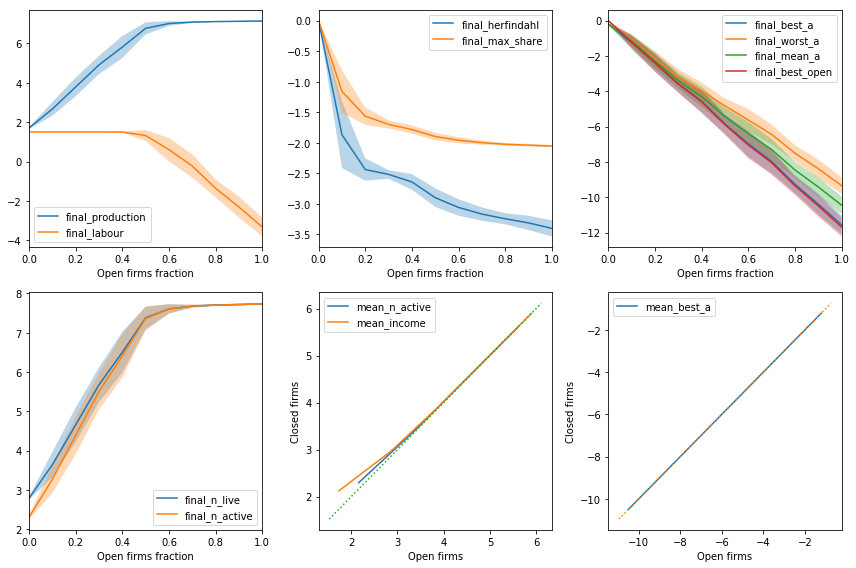

In [34]:
# Plot various results as a function of the fraction of open firms (include one-sigma ranges)

n_x = 3
n_y = 2
fig = plt.figure(figsize=(12, 8))

col_lists = [
    ['final_production', 'final_labour'],
    ['final_herfindahl', 'final_max_share'],
    ['final_best_a', 'final_worst_a', 'final_mean_a', 'final_best_open'],
    ['final_n_live', 'final_n_active'],
]

for idx, cols in enumerate(col_lists):
    ax = fig.add_subplot(n_y, n_x, idx+1)
    meanlog_summary[cols].plot(ax=ax)
    for col in cols:
        plt.fill_between(meanlog_summary.index,
                         meanlog_summary[col] - stdlog_summary[col],
                         meanlog_summary[col] + stdlog_summary[col],
                         alpha=0.3)
    plt.xlabel('Open firms fraction')

ax = fig.add_subplot(n_y, n_x, 5)
plt.plot(meanlog_summary['mean_n_active_open'], meanlog_summary['mean_n_active_closed'], label='mean_n_active')
plt.plot(meanlog_summary['mean_income_open'], meanlog_summary['mean_income_closed'], label='mean_income')
plt.plot(plt.xlim(), plt.xlim(), ':')
plt.legend()
plt.xlabel('Open firms')
plt.ylabel('Closed firms')

ax = fig.add_subplot(n_y, n_x, 6)
plt.plot(meanlog_summary['mean_best_a_open'], meanlog_summary['mean_best_a_closed'], label='mean_best_a')
plt.plot(plt.xlim(), plt.xlim(), ':')
plt.legend()
plt.xlabel('Open firms')
plt.ylabel('Closed firms')

plt.tight_layout()

Production rates increase up to an openness fraction of 0.5, above which they level out. Employment drops at higher openness.

A small amount of openness is very effective in breaking up monopolies.

Technology improves monotonically as openness increases.

In the low-openness regime, closed firms have higher income than open firms.

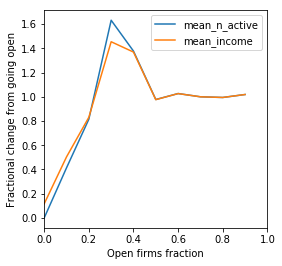

In [35]:
fig = plt.figure(figsize=(4, 4))
(mean_summary_delta['mean_n_active_open'] / mean_summary['mean_n_active_closed']).plot(label='mean_n_active')
(mean_summary_delta['mean_income_open'] / mean_summary['mean_income_closed']).plot(label='mean_income')
plt.legend()
plt.xlabel('Open firms fraction')
plt.ylabel('Fractional change from going open')

If the current fraction of open firms is 0.2 or less, a closed firm going open can expect to decrease its income due to the advantage it offers its competitors. Between a fraction of 0.2 and 0.5 this is overcome by the increase in technology on offer, and the firm can expect to increase its income by going open. At a fraction of 0.5 or above the expected income is the same whether the firm goes open or not.